## Primer Dataset

In [1]:
#Importamos librerías que pueden ser útiles
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema #Útil para encontrar extremos relativos
from geneticalgorithm import geneticalgorithm as ga  #Se van a usar métodos genéticos para la minimización

#Cargamos el dataset principal y mapping como DataFrame's de Pandas
path_dataset = r'C:\Users\ivanp\OneDrive\Escritorio\Universidad (compartido)\oliver-wyman-pd-optimization\Sample - Main dataset\data_calibration_recruiting.csv'
main_dataset_df = pd.read_csv(path_dataset,";")

path_mapping = r'C:\Users\ivanp\OneDrive\Escritorio\Universidad (compartido)\oliver-wyman-pd-optimization\Sample - Main dataset\mappings.csv'
mapping_df = pd.read_csv(path_mapping,";")

C:\Users\ivanp\AppData\Local\Temp\ipykernel_7104\2919862947.py:11: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  main_dataset_df = pd.read_csv(path_dataset,";")
C:\Users\ivanp\AppData\Local\Temp\ipykernel_7104\2919862947.py:14: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  mapping_df = pd.read_csv(path_mapping,";")


### Definimos la función que se busca minimizar

In [6]:
def J(X): #X es un array (el de los 'min score' que buscamos)
    #De cara a optimizar el funcionamiento y tiempo de procesamiento de la función, introducimos ya penalizaciones:
    
    X = np.sort(X) #Hacemos esto para que el algoritmo genético, que trabaja con arrays aleatorios y por tanto, a priori, desordenados...
    #...no se vea afectado por la falta de monotonía, es decir, demos el input que demos, lo primero es ordenar el array de 'min score'
    
    #FALTA INTRODUCIR UNA PENALIZACIÓN MÁS 
    
    #Construimos la tabla que queremos "rellenar"
    global tabla
    tabla = pd.DataFrame({'rating' : mapping_df['rating'], 'min score' : X, 'obs':0, 'PD scale' : mapping_df['pd_scale'],
                      'LRA DR':0})
    
    #Añadimos una columna al main_dataset_df de cara a poner ratings
    global main_dataset_df
    main_dataset_df['rating'] = 0
    
    #Bucle para contar el número de préstamos de cada rating teniendo en cuenta la reestructuración
    i = 1
    while i < len(X):
        
        #Contamos las obs (número de préstamos en cada rating)
        tabla['obs'][i-1] = tabla['obs'][i-1] + len(main_dataset_df[(main_dataset_df['score']>=X[i-1]) & (main_dataset_df['score']<X[i]) & 
                                               (main_dataset_df['b_reestructured'] == 0)])
        tabla['obs'][i] = tabla['obs'][i] + len(main_dataset_df[(main_dataset_df['score']>=X[i-1]) & (main_dataset_df['score']<X[i]) & 
                                               (main_dataset_df['b_reestructured'] == 1)])
        
        #Ahora tengamos en cuenta que 
        main_dataset_df.loc[(main_dataset_df['score']>=X[i-1]) & (main_dataset_df['score']<X[i]) & 
                            (main_dataset_df['b_reestructured'] == 0),'rating'] = tabla['rating'][i-1]
        main_dataset_df.loc[(main_dataset_df['score']>=X[i-1]) & (main_dataset_df['score']<X[i]) & 
                            (main_dataset_df['b_reestructured'] == 1),'rating'] = tabla['rating'][i]
        
        i = i + 1
    #De esta forma no se tiene el en cuenta el último rating, pero lo introducimos usando que ahora i ya tiene el último índice:
    tabla['obs'][i-1] = tabla['obs'][i-1] + len(main_dataset_df[main_dataset_df['score']>=X[i-1]])
    main_dataset_df.loc[main_dataset_df['score']>=X[i-1],'rating'] = tabla['rating'][i-1]
    #En el último rating están aquellos...
    #...préstamos que tengan simplemente un score mayor al último valor de 'min score'
    
    
    #Ya tenemos la tabla preparada para hacer cálculos:
    global dataset_agrupado
    
    dataset_agrupado = main_dataset_df.groupby(by = ['rating','snapshot']).agg({'b_default' : ['sum','count']})
    #Para rating y snapshot fijado contamos el número de préstamos que hay y además sumamos los b_default
    dataset_agrupado['DR'] = dataset_agrupado.iloc[:,0] / dataset_agrupado.iloc[:,1] #No hay problema en la división, por construcción no se divide entre 0
    #De esta forma ya tenemos el DR que queríamos.

    #Resta sumar los DR en todos los snapshots dado un mismo rating y dividir entre el número de dichos snapshots
    LRA_DR = dataset_agrupado.groupby('rating').DR.agg(sum) / dataset_agrupado.groupby('rating').DR.agg('count')
    LRA_DR = pd.DataFrame(LRA_DR) #Creo DataFrame por comodidad
    #Por explicarlo, en el numerador agrupamos de nuevo solo por rating y sumamos los DR y después en el denominador simplemente dividimos
    
    #Introducimos el LRA_DR calculado en la columna que habíamos reservado en nuestra tabla:
    tabla = tabla.set_index('rating') #Simplemente hago esto para que se reconozcan bien los índices al meter la nueva columna
    tabla['LRA DR'] = LRA_DR
    tabla = tabla.reset_index() #Deshago lo de los índices
    #Se podría observar que, si no hay observaciones en un cierto rating, el LRA DR asociado es NaN, lo cual simplemente hace ver...
    #...que en efecto no hay observaciones y no se puede calcular dicho LRA DR. Para los cálculos siguientes se tendrá en cuenta esto
    
    #UNA VEZ TENEMOS LA TABLA QUE NOS INTERESA CREADA, HAY QUE INTRODUCIR LA FUNCIÓN J A MINIMIZAR. Usamos el razonamiento explicado:
    Err_rel = abs(tabla['PD scale'] - tabla['LRA DR'])/tabla['PD scale']#Esencialmente esa es la función a penalizar a la que añadimos penalización
    
    #Penalización si no hay unimodalidad:
    a = np.array(tabla['obs'])
    a = np.concatenate((np.array([-1,-1]),a)) ##Introducimos dos valores negativos al principio con el objetivo de que si las observaciones...
    #... empiezan con un máximo, la función lo cuente como extremo relativo y se cumpla la unimodalidad
    max_rel = argrelextrema(a, np.greater) #Lo único que nos importa realmente es el número de extremos relativos
    if len(max_rel[0]) != 1: #Buscamos que haya un único máximo (unimodalidad)
        return float('inf')
    
    #Tampoco queremos que haya mínimos:
    b = np.array(tabla['obs'])
    b = np.concatenate((np.array([-1,-1]),b)) ##Introducimos dos valores negativos al principio con el objetivo de que si las observaciones...
    #... empiezan con un máximo, la función lo cuente como extremo relativo y se cumpla la unimodalidad
    min_rel = argrelextrema(b, np.less) #Lo único que nos importa realmente es el número de extremos relativos
    if len(min_rel[0]) != 0: #Buscamos que haya un único máximo (unimodalidad)
        return float('inf')
    
    #Penalización si hay porcentaje alto en un mismo rating
    obs_rel = tabla['obs'] / len(main_dataset_df)
    if np.array_equal(np.array(obs_rel < 0.35),np.array([True]*len(tabla))) == False: #Nos aseguramos que como mucho la concentración en un mismo rating sea del 40%
        return float('inf')
    
    #Penalización si hay demasiados ratings sin observaciones
    if len(tabla[tabla['obs'] == 0])/len(tabla) > 2/len(tabla):
        return float('inf')
    
    return np.nansum(Err_rel) #Tenemos en cuenta que puede haber valores con NaN y usamos numpy para tratar esos valores como 0
    #De esta forma tan sencilla ya tenemos introducida la primera parte de la función a minimizar
    

#### Mejor solución hasta ahora (ha tardado en torno a 25 minutos)

 The best solution found:                                                                           
 [2.51546243 7.99694546 4.23024273 6.87433144 5.62485738 3.75805367
 3.23875461 7.6315386  8.38021428 6.33987569 7.31889533 4.71926091
 8.84000949 9.51813107]

 Objective function:
 5.306201224752775


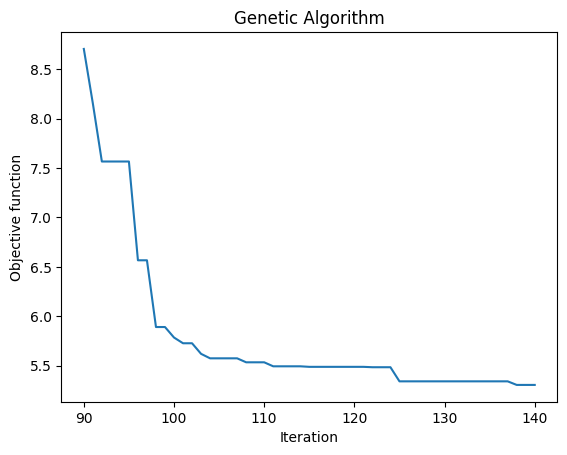

In [318]:
import warnings
warnings.filterwarnings('ignore')
#Ahora simplemente aplicamos el algoritmo genético a nuestra función J(X)
varbound=np.array([[min(main_dataset_df['score'])-0.5,min(main_dataset_df['score'])-0.1], [min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])]])

algorithm_param = {'max_num_iteration': 140,\
                   'population_size':180,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=J,dimension=len(mapping_df),variable_type='real',variable_boundaries=varbound,function_timeout = 10000,
        algorithm_parameters=algorithm_param)
model.run()

In [319]:
X = np.array([2.51546243, 7.99694546, 4.23024273, 6.87433144, 5.62485738, 3.75805367,
 3.23875461, 7.6315386,  8.38021428, 6.33987569, 7.31889533, 4.71926091,
 8.84000949, 9.51813107])
J(X)
tabla

,rating,min score,obs,PD scale,LRA DR
0,A,2.515462,12,0.000477,0.000000
1,A-,3.238755,42,0.000690,0.000000
2,BBB+,3.758054,130,0.000986,0.000000
3,BBB,4.230243,357,0.001339,0.000000
4,BBB-,4.719261,1091,0.001873,0.002063
5,BB+,5.624857,1454,0.002704,0.001179
6,BB,6.339876,1641,0.004512,0.003884
7,BB-,6.874331,1725,0.007774,0.007376
8,B+,7.318895,1700,0.015796,0.015479
9,B,7.631539,1185,0.026901,0.027999


## Nuevo DataSet

In [7]:
#Cargamos el dataset principal y mapping como DataFrame's de Pandas
path_dataset = r'C:\Users\ivanp\OneDrive\Escritorio\Universidad (compartido)\oliver-wyman-pd-optimization\data_calibration_recruiting_oos.csv'
main_dataset_df = pd.read_csv(path_dataset,";")

path_mapping = r'C:\Users\ivanp\OneDrive\Escritorio\Universidad (compartido)\oliver-wyman-pd-optimization\mappings_oos.csv'
mapping_df = pd.read_csv(path_mapping,";")

In [344]:
warnings.filterwarnings('ignore')
J(np.array([0,1,2,4,5,6,7,8,9,9.1,9.2,9.6]))

inf

### Algoritmo genético para nuevo dataset

 The best solution found:                                                                           
 [4.96434696 5.15424848 7.88381547 8.6875067  6.05003013 6.12451804
 8.32912731 9.26324817 7.56562608 7.19598961 9.2661582  6.48656356]

 Objective function:
 5.345734394860922


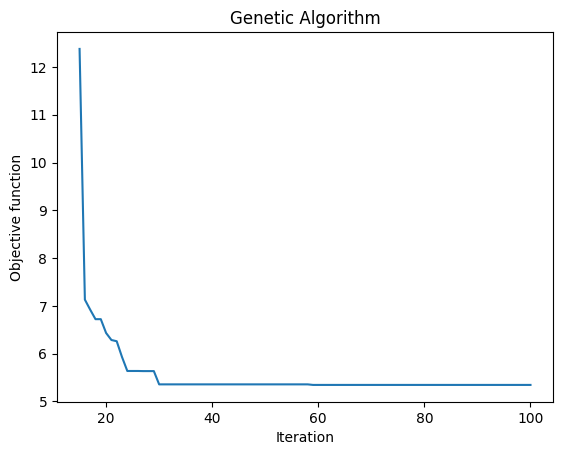

In [8]:
import warnings
warnings.filterwarnings('ignore')
#Ahora simplemente aplicamos el algoritmo genético a nuestra función J(X)
varbound=np.array([[min(main_dataset_df['score'])-0.5,min(main_dataset_df['score'])-0.1], [min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])]])

algorithm_param = {'max_num_iteration': 100,\
                   'population_size':300,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=J,dimension=len(mapping_df),variable_type='real',variable_boundaries=varbound,function_timeout = 10000,
        algorithm_parameters=algorithm_param)
model.run()

In [9]:
X = np.array([4.96434696, 5.15424848, 7.88381547, 8.6875067,  6.05003013, 6.12451804,
 8.32912731, 9.26324817, 7.56562608, 7.19598961, 9.2661582,  6.48656356])
J(X)
tabla

,rating,min score,obs,PD scale,LRA DR
0,BBB+,4.964347,2,0.000986,0.000000
1,BBB,5.154248,2,0.001339,0.000000
2,BBB-,6.050030,2,0.001873,0.000000
3,BB+,6.124518,14,0.002704,0.000000
4,BB,6.486564,134,0.004512,0.004444
5,BB-,7.195990,168,0.007774,0.005051
6,B+,7.565626,281,0.015796,0.017508
7,B,7.883815,357,0.026901,0.029100
8,B-,8.329127,180,0.054395,0.041137
9,CCC+,8.687507,61,0.108986,0.086376


#### Otro intento dataset pequeño
Mucha población y pocas iteraciones

 The best solution found:                                                                           
 [4.91872907 8.91703592 8.18857444 9.59775738 7.72896488 5.60282085
 6.20389412 8.94968757 7.12617161 6.00770481 6.39968589 7.42272328]

 Objective function:
 5.327351563706845


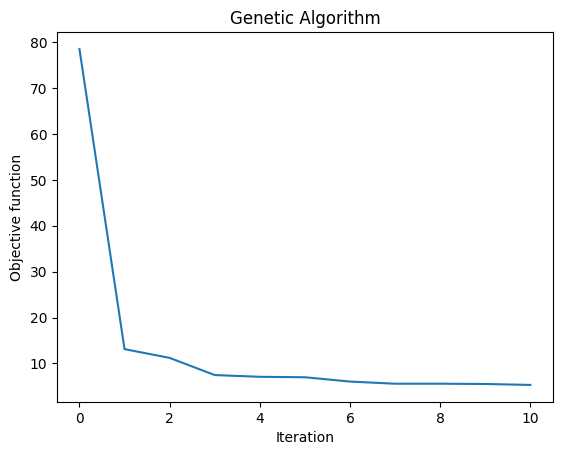

In [10]:
import warnings
warnings.filterwarnings('ignore')
#Ahora simplemente aplicamos el algoritmo genético a nuestra función J(X)
varbound=np.array([[min(main_dataset_df['score'])-0.5,min(main_dataset_df['score'])-0.1], [min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])],
         [min(main_dataset_df['score']),max(main_dataset_df['score'])],[min(main_dataset_df['score']),max(main_dataset_df['score'])]])

algorithm_param = {'max_num_iteration': 10,\
                   'population_size':1000,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=J,dimension=len(mapping_df),variable_type='real',variable_boundaries=varbound,function_timeout = 10000,
        algorithm_parameters=algorithm_param)
model.run()

In [12]:
X = np.array([4.91872907, 8.91703592, 8.18857444, 9.59775738, 7.72896488, 5.60282085,
 6.20389412, 8.94968757, 7.12617161, 6.00770481, 6.39968589, 7.42272328])
J(X)
tabla

,rating,min score,obs,PD scale,LRA DR
0,BBB+,4.918729,2,0.000986,0.000000
1,BBB,5.602821,2,0.001339,0.000000
2,BBB-,6.007705,3,0.001873,0.000000
3,BB+,6.203894,6,0.002704,0.000000
4,BB,6.399686,118,0.004512,0.004831
5,BB-,7.126172,119,0.007774,0.006536
6,B+,7.422723,207,0.015796,0.015070
7,B,7.728965,385,0.026901,0.028024
8,B-,8.188574,319,0.054395,0.028330
9,CCC+,8.917036,34,0.108986,0.112500
